# 1: Setup and Data Exploration

Author: Daniel Lusk

## Imports

In [7]:
import json
import os
from pathlib import Path

import rioxarray as riox
import numpy as np
import geopandas as gpd
import pandas as pd
from PreprocessingConfig import PreprocessingConfig
from utils.datasets import Dataset, Unit, resample_dataset, CollectionName, GBIFBand

from utils.visualize import plot_distributions

%load_ext autoreload
%autoreload 2

# Load configuration
config = PreprocessingConfig()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## TRY + GBIF/iNaturalist trait maps

### Visualize TRY + GBIF/iNaturalist trait maps

First, let's look at the trait maps generated from TRY/iNaturalist observations by [Wolf, et al. (2022)](https://doi.org/10.1038/s41559-022-01904-x).

In [4]:
gbif = Dataset(
    res=0.5,
    collection_name=CollectionName.GBIF,
    band=GBIFBand.MEAN
)

splot = Dataset(
    res=0.5,
    collection_name=CollectionName.SPLOT,
    band=GBIFBand.MEAN
)

gbif_ln = Dataset(
    res=0.5,
    collection_name=CollectionName.GBIF_LN,
    band=GBIFBand.MEAN
)

splot_ln = Dataset(
    res=0.5,
    collection_name=CollectionName.SPLOT_LN,
    band=GBIFBand.MEAN
)

In [10]:
# Map trait IDs to trait names

# Rename response variable values according to the trait id -> trait name mapping
with open("./trait_id_to_trait_name.json", "r") as f:
    mapping = json.load(f)

# Replace each column in gbif.df and splot.df according to the pattern "TRYgapfilled_X{trait_id}_" with {trait_name}
for trait_id, trait_name in mapping.items():
    gbif.df = gbif.df.rename(columns={f"GBIF_TRYgapfilled_X{trait_id}_05deg_mean": f"GBIF_{trait_name}_05deg_mean"})
    splot.df = splot.df.rename(columns={f"sPlot_TRYgapfilled_X{trait_id}_05deg_mean": f"sPlot_{trait_name}_05deg_mean"})


### GBIF trait distributions

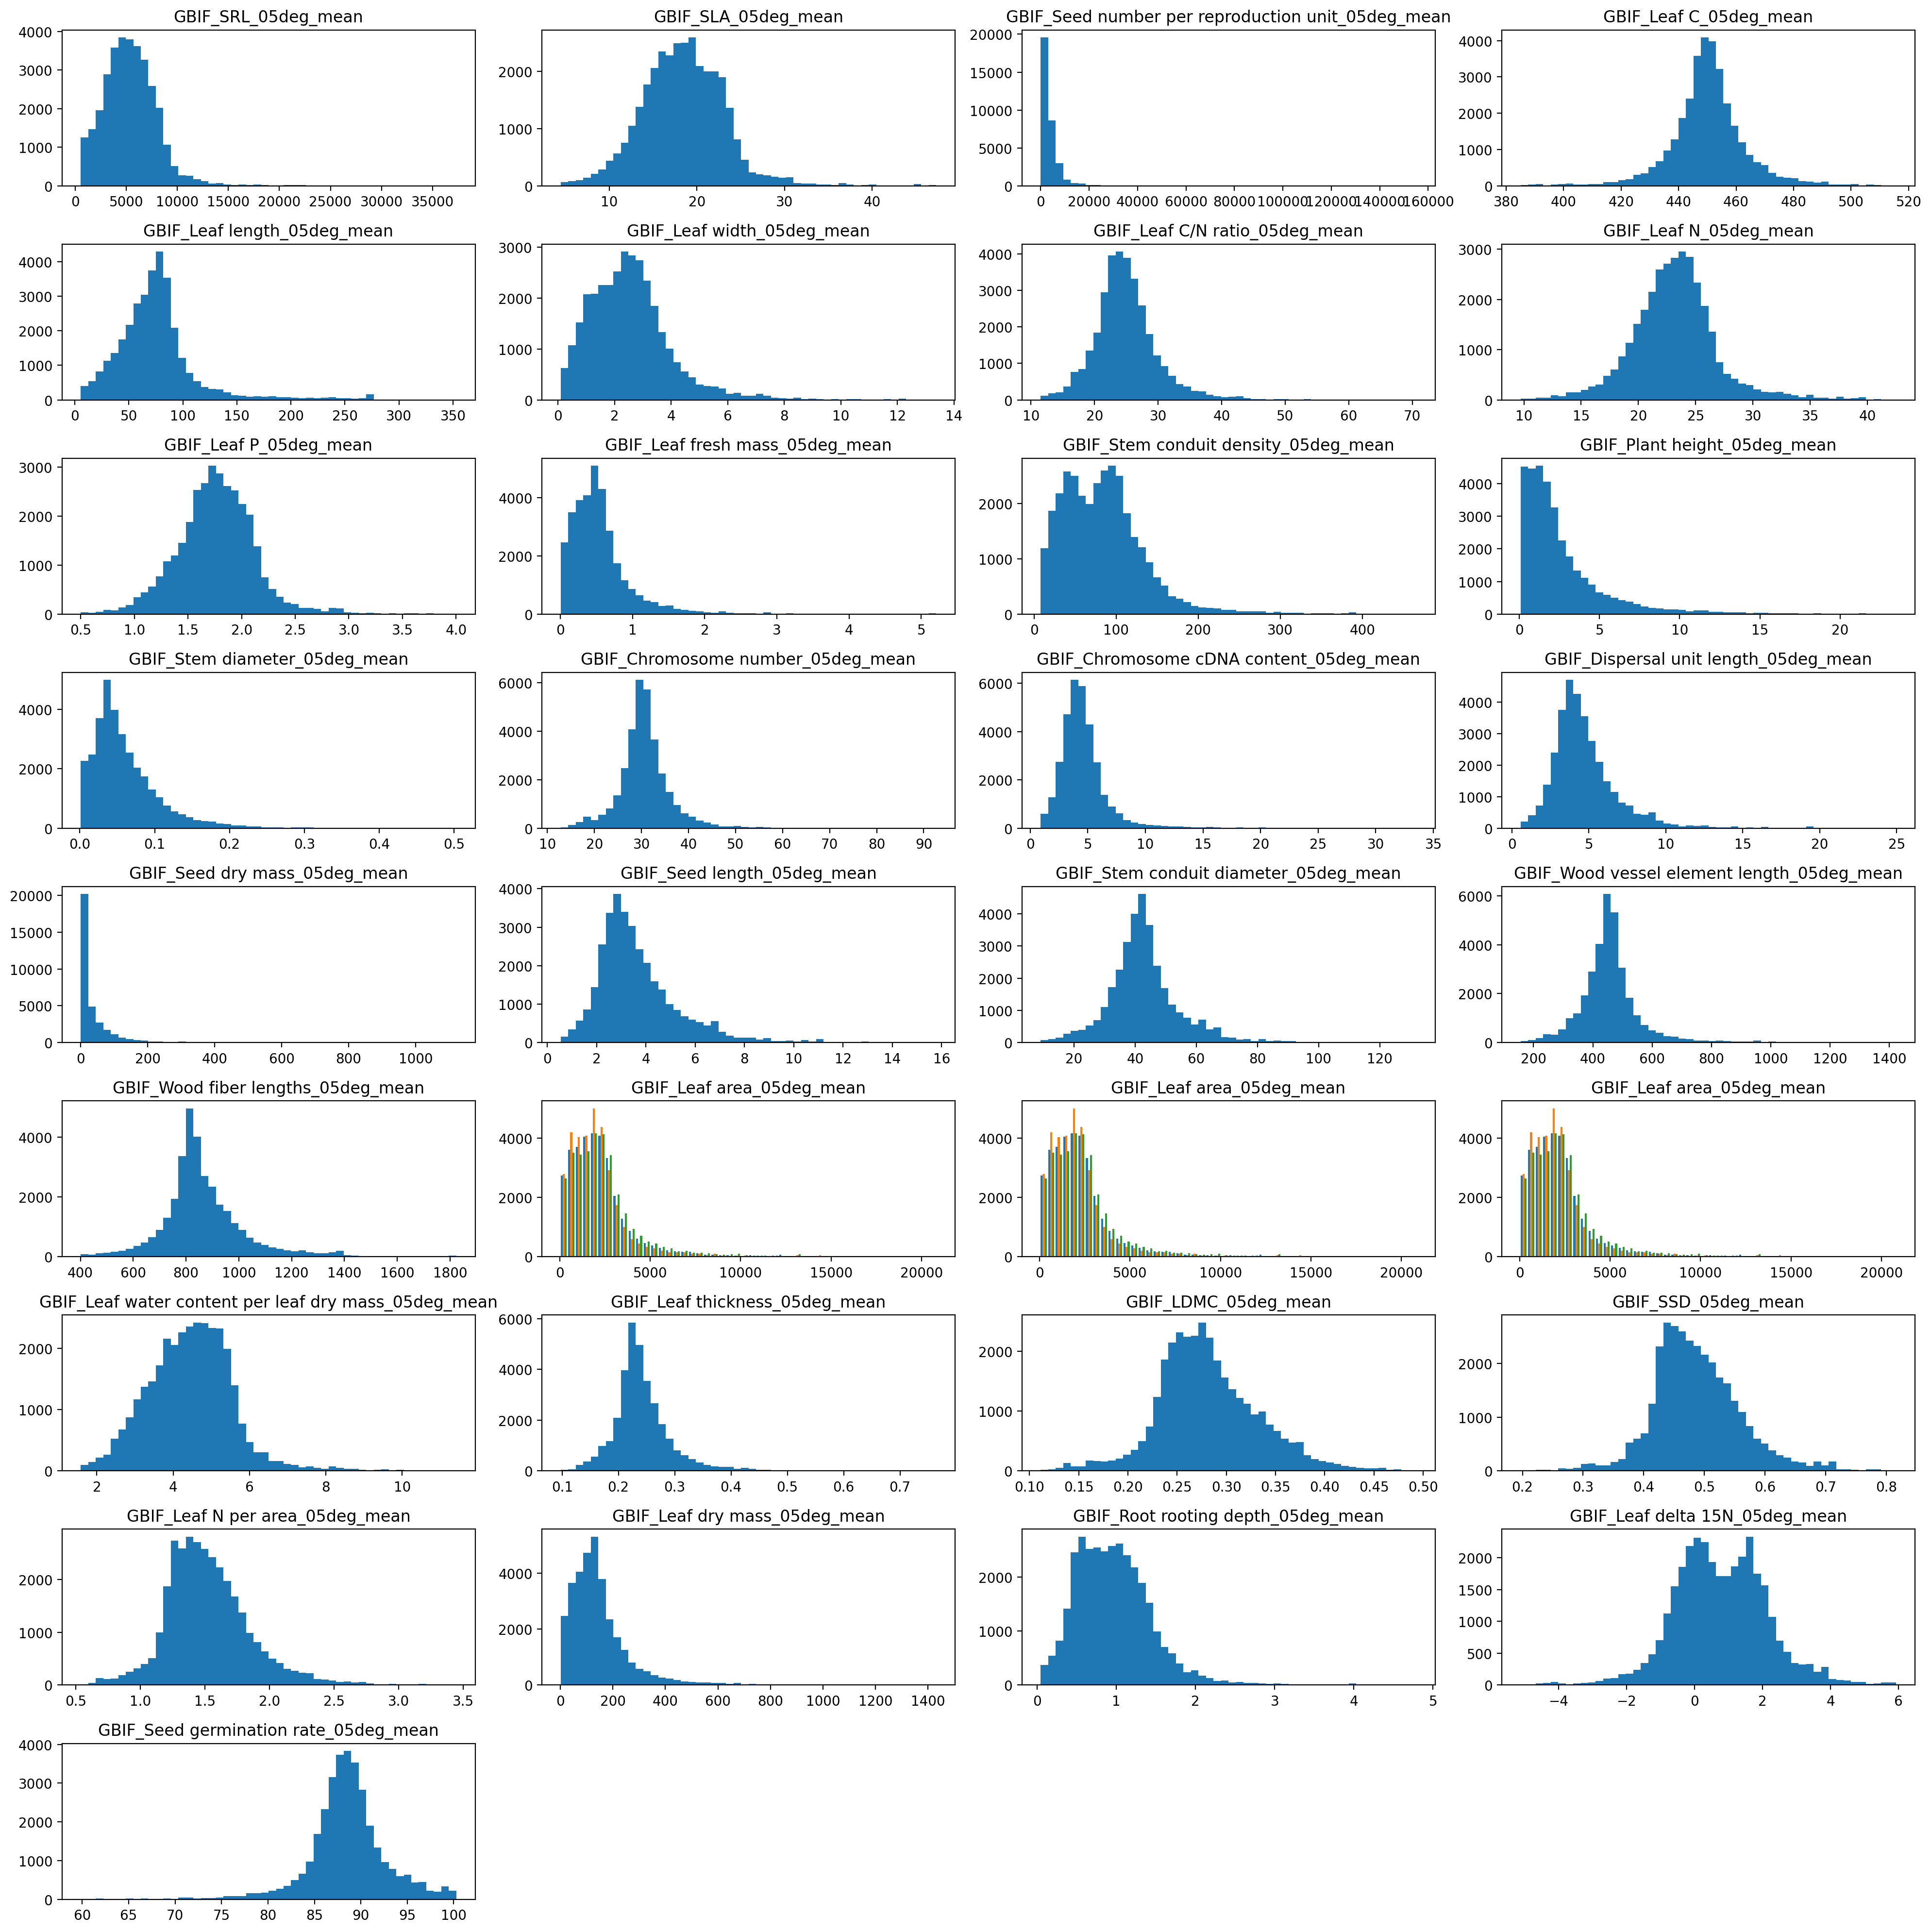

In [11]:
df = gbif.df.drop(columns=["geometry"])

plot_distributions(df)


### sPlotOpen trait distributions

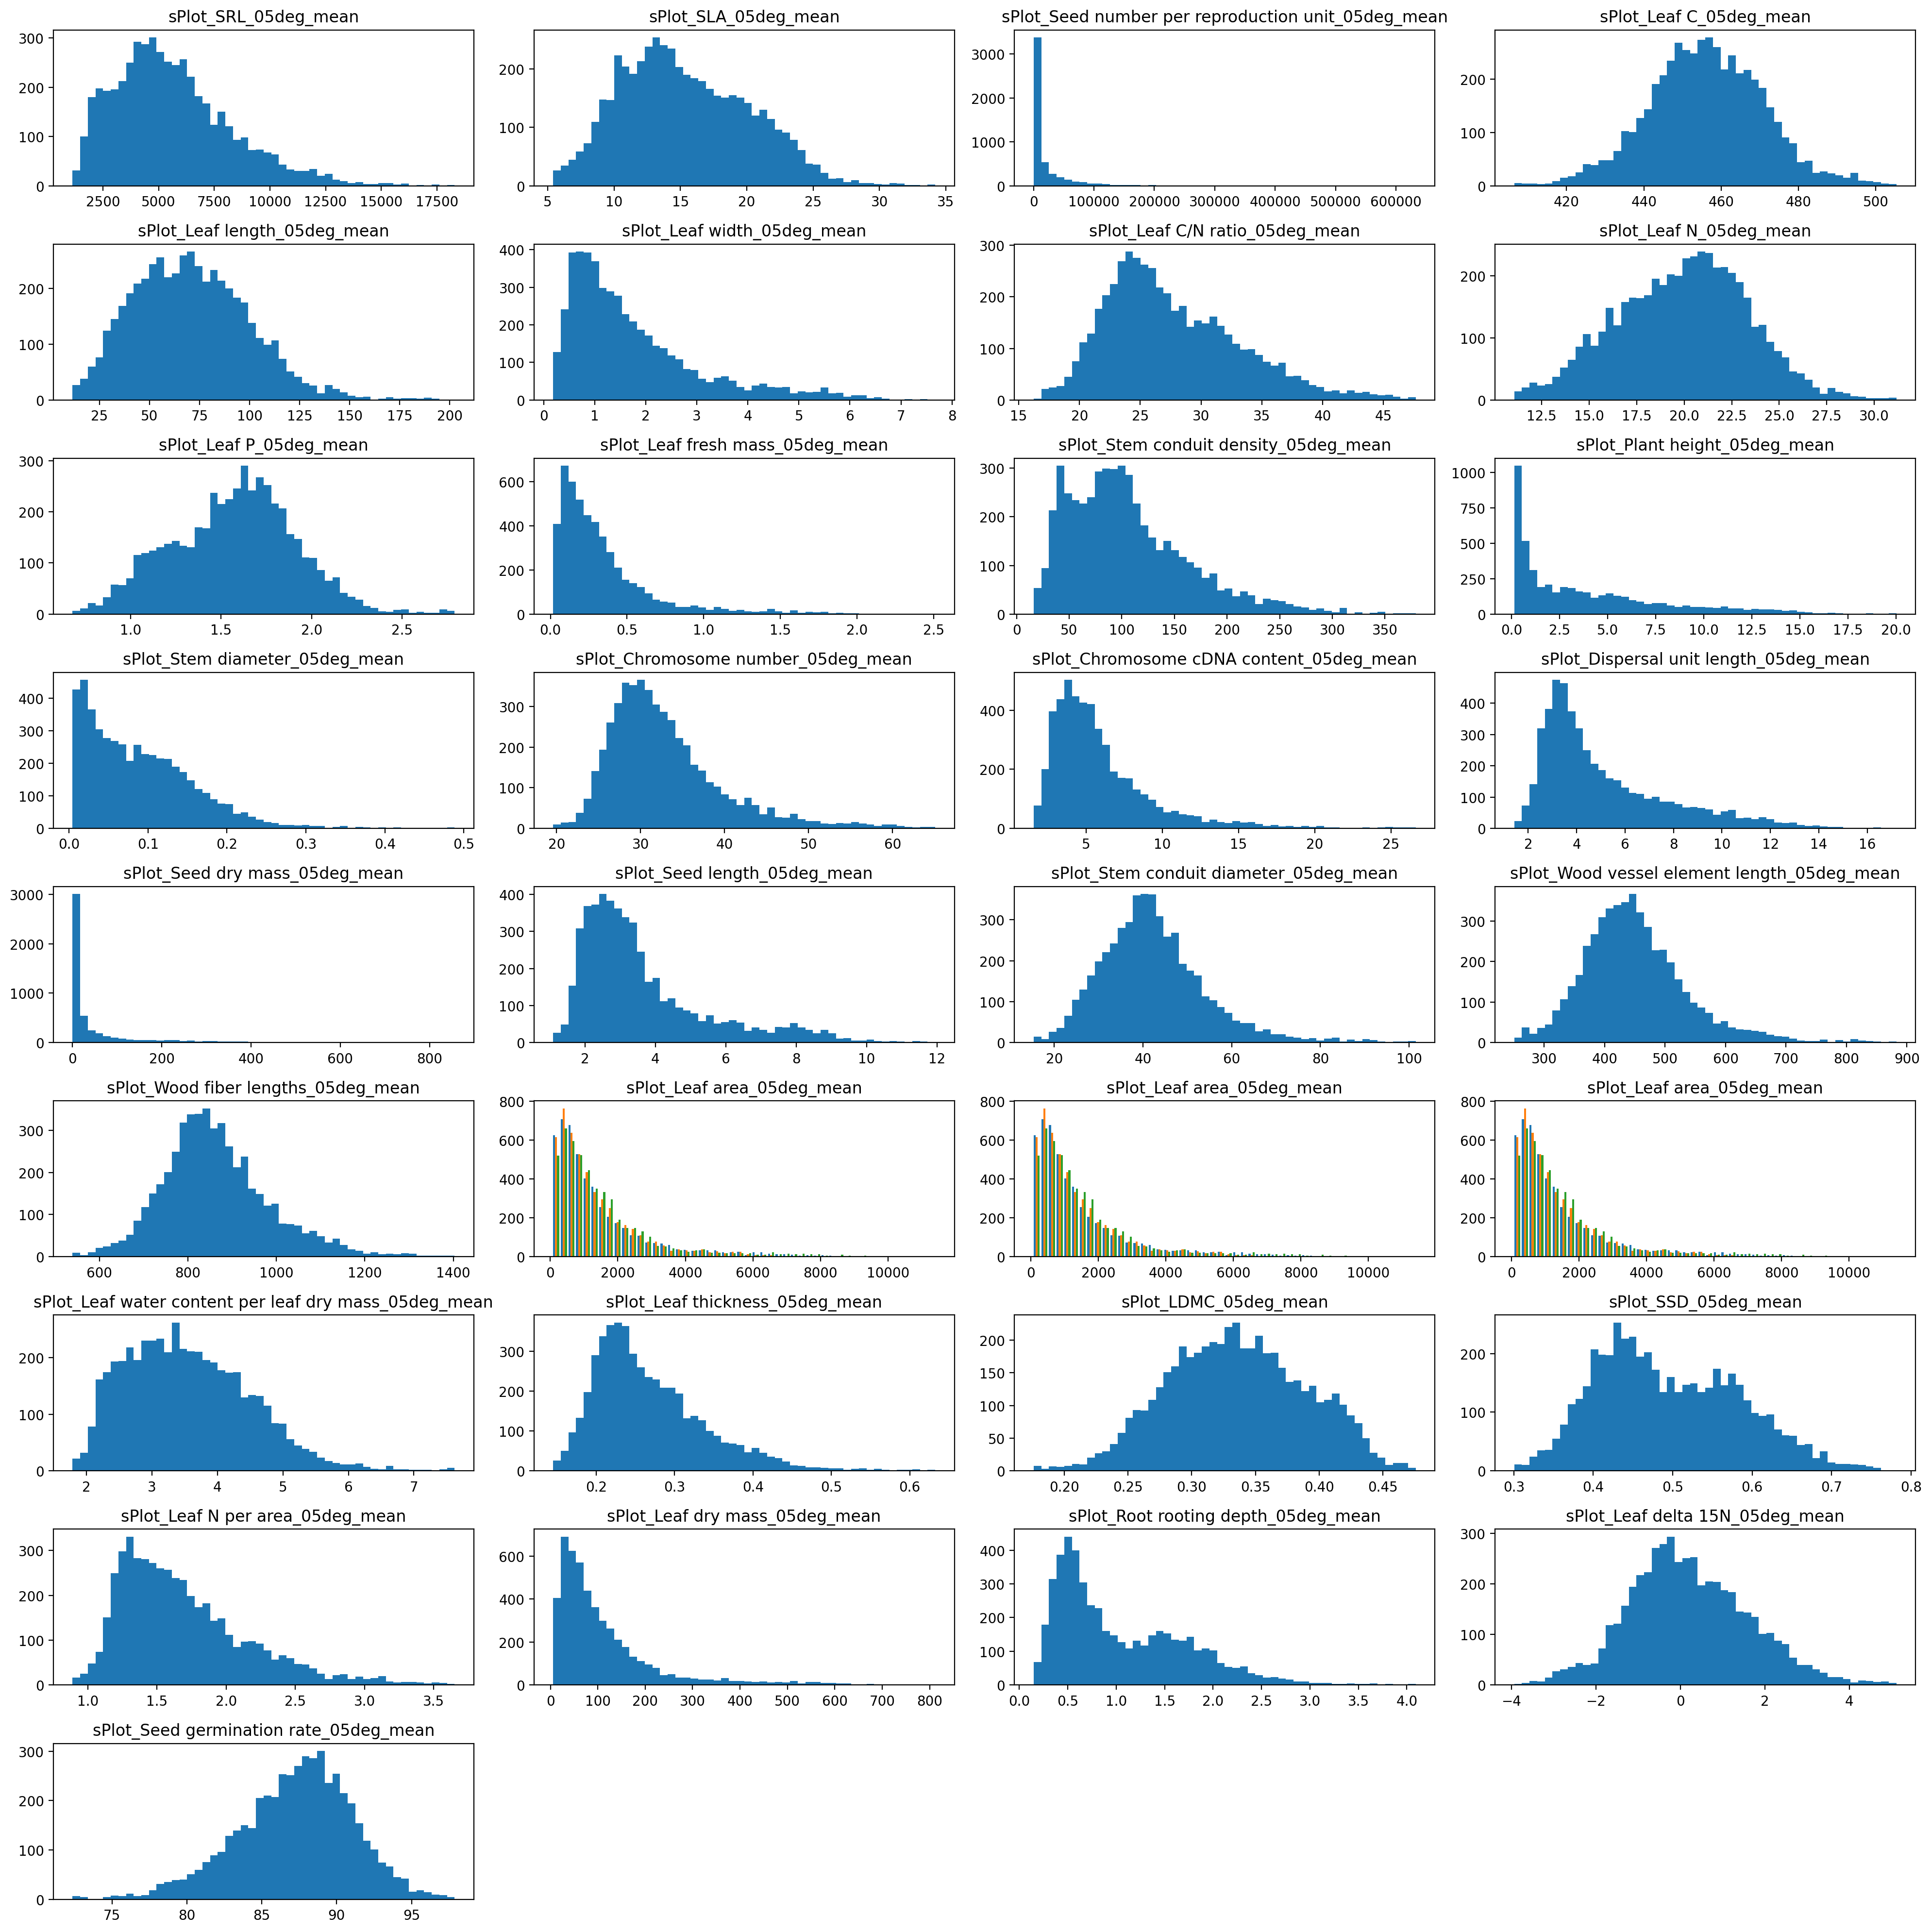

In [12]:
df = splot.df.drop(columns=["geometry"])

plot_distributions(df)

### Log-transform GBIF and sPlotOpen data

In [ ]:
# Log-transform the GBIF data
gbif_ln = pd.DataFrame(np.log(gbif.df[gbif.cols]), columns=gbif.cols)
gbif_ln.columns = [f"{col}_ln" for col in gbif_ln.columns]
gbif_ln = gpd.GeoDataFrame(gbif_ln, geometry=gbif.df.geometry, crs=gbif.df.crs)

splot_ln = pd.DataFrame(np.log(splot.df[splot.cols]), columns=splot.cols)
splot_ln.columns = [f"{col}_ln" for col in splot_ln.columns]
splot_ln = gpd.GeoDataFrame(splot_ln, geometry=splot.df.geometry, crs=splot.df.crs)

plot_distributions(gbif_ln.drop(columns=["geometry"]))
plot_distributions(splot_ln.drop(columns=["geometry"]))

Save the data to disk

In [ ]:
gbif_out_path = Path("data/gbif_ln/0.5_deg/gbif_ln_mean_0.5_deg.parq")
gbif_out_path.parent.mkdir(parents=True, exist_ok=True)
gbif_ln.to_parquet(gbif_out_path, compression="zstd", compression_level=2)

splot_out_path = Path("data/splot_ln/0.5_deg/splot_ln_mean_0.5_deg.parq")
splot_out_path.parent.mkdir(parents=True, exist_ok=True)
splot_ln.to_parquet(splot_out_path, compression="zstd", compression_level=2)

## WorldClim data

Load the tifs and resample to all resolutions needed

In [ ]:
wc = Dataset(
    res=0.5,
    unit=Unit.DEGREE,
    collection_name=config.WC_name,
    bio_ids=None,
)

# resample_dataset(dataset=wc, resolution=0.01, unit=Unit.DEGREE, resample_alg=4)

Standardize files to uniform GeoTIFF layout

In [ ]:
for fp in wc.fpaths:
    fp = Path(fp)
    parent_dir = fp.parent
    out_dir = parent_dir / "standardized"
    out_dir.mkdir(exist_ok=True)

    ds = riox.open_rasterio(fp)
    ds.rio.set_crs(ds.rio.crs, inplace=True)
    ds = ds.astype("float32")
    ds = ds.where(ds != ds.rio.nodata)
    ds.rio.write_nodata(ds.rio.nodata, encoded=True, inplace=True)

    ds.rio.to_raster(
        out_dir / f"{fp.stem}.tif",
        dtype="float32",
        compress="zstd",
        tiled=True,
        blockxsize=256,
        blockysize=256,
        predictor=2,
        num_threads=18,
    )

Compute Preciptation Annual Range by subtracting BIO14 from BIO13

In [ ]:
bio_13 = bio_gdfs.loc[:, ["bio_13" in x for x in bio_gdfs.columns]].values
bio_14 = bio_gdfs.loc[:, ["bio_14" in x for x in bio_gdfs.columns]].values
bio_gdfs["wc2.1_10m_bio_13-14"] = bio_13 - bio_14

## MODIS Terra Surface Reflectance bands 1-5

1. Get bands 1-5 of MODIS Terra Surface Reflectance dataset
2. mask clouds
3. aggregate into monthly collections
4. export to Google Drive with a target resolution of ~1km at the equator (0.008983152841195, -0.008983152841195)

In [ ]:
if config.gee_export:
    import ee
    import utils.gee as gee

    # ee.Authenticate() # Uncomment if not already authenticated
    ee.Initialize()

    # Get MODIS Terra Surface Reflectance image collection for its first five years of operation
    # (2000-03-01 - 2001-03-01)
    ds, de = "2000-03-01", "2005-03-02"
    bands = [
        "sur_refl_b01",
        "sur_refl_b02",
        "sur_refl_b03",
        "sur_refl_b04",
        "sur_refl_b05",
    ]
    modis_tsr = ee.ImageCollection("MODIS/061/MOD09GA").filterDate(ds, de)

    # Mask clouds
    qa_band = "state_1km"
    modis_tsr_masked = gee.mask_clouds(modis_tsr, qa_band)

    # Aggregate the image collection into monthly averages for each band
    tsr_bands_monthly = []
    for ds in bands:
        monthly = gee.aggregate_ic(modis_tsr_masked.select(ds), ds, de)
        tsr_bands_monthly.append(monthly)

    tsr_monthly_means = []
    for band_ic in tsr_bands_monthly:
        tsr_monthly_means.append(gee.aggregate_ic_monthly(band_ic, ds, de))

    # Combine the five bands into a single image collection
    tsr_monthly_means = (
        tsr_monthly_means[0]
        .combine(tsr_monthly_means[1])
        .combine(tsr_monthly_means[2])
        .combine(tsr_monthly_means[3])
        .combine(tsr_monthly_means[4])
    )

    # Reproject the image collection to EPSG:4326 with a scale of 1km
    tsr_monthly_means = tsr_monthly_means.map(lambda x: x.reproject("EPSG:4326", None, 1000))

    # Unmask the image collection and convert to int16 (because NoData values are replaced with 0 when converting to int16)
    tsr_monthly_means = tsr_monthly_means.map(lambda x: x.unmask(-32768))
    tsr_monthly_means = tsr_monthly_means.map(lambda x: x.toInt16())

    # Export images to Google Drive
    gee.export_collection(
        collection=tsr_monthly_means, folder="multiband_monthly_averages"
    )

5. Merge semi-global observations for each band/month (See `scripts/merge_files.py`)

6. Downsample to match resolution of trait maps (0.5 deg)

In [ ]:
modis = Dataset(
    res=0.5,
    unit=Unit.DEGREE,
    collection_name=CollectionName.MODIS,
)

# Uncomment to resample the MODIS dataset to another resolution
# resample_dataset(dataset=modis, resolution=0.01, unit=Unit.DEGREE)

In [ ]:
for fp in modis.fpaths:
    fp = Path(fp)
    parent_dir = fp.parent
    out_dir = parent_dir / "standardized"
    out_dir.mkdir(exist_ok=True)

    ds = riox.open_rasterio(fp)
    ds.rio.set_crs(ds.rio.crs, inplace=True)
    ds = ds.astype("float32")
    ds = ds.where(ds != ds.rio.nodata)
    ds.rio.write_nodata(ds.rio.nodata, encoded=True, inplace=True)

    ds.rio.to_raster(
        out_dir / f"{fp.stem}.tif",
        dtype="float32",
        compress="zstd",
        tiled=True,
        blockxsize=256,
        blockysize=256,
        predictor=2,
        num_threads=18,
    )

## ISRIC soil data

1. Download soil data from [ISRIC](https://files.isric.org/soilgrids/latest/data/)
2. Reproject to WGS84, and resample to ~1km resolution

See `get_soil_data_multi.py`

3. Reproject and downsample to Wolf trait maps CRS

In [ ]:
soil = Dataset(
    res=0.5,
    unit=Unit.DEGREE,
    collection_name=CollectionName.SOIL,
)

# Uncomment to resample the ISRIC dataset to another resolution
# resample_dataset(dataset=soil, resolution=0.01, unit=Unit.DEGREE)

In [ ]:
for fp in soil.fpaths:
    fp = Path(fp)
    parent_dir = fp.parent
    out_dir = parent_dir / "standardized"
    out_dir.mkdir(exist_ok=True)

    ds = riox.open_rasterio(fp)
    ds.rio.set_crs(ds.rio.crs, inplace=True)
    ds = ds.astype("int16")
    ds = ds.where(ds != ds.rio.nodata)
    ds.rio.write_nodata(ds.rio.nodata, encoded=True, inplace=True)
    ds.rio.to_raster(
        out_dir / f"{fp.stem}.tif",
        dtype="int16",
        compress="zstd",
        tiled=True,
        blockxsize=256,
        blockysize=256,
        predictor=2,
        num_threads=18,
    )

# VODCA

Downsample all three bands spatially, resample to monthly, and save to disk

In [ ]:
import xarray as xr
import numpy as np
import geopandas as gpd

def daily_to_multiyear_monthly(
    ds: xr.Dataset, band_name: str, out_name: str, p_dir: str
) -> None:
    """Converts daily data to multiyear monthly data and saves to disk"""
    ds = ds.drop_vars(["sensor_flag", "processing_flag"])
    ds = ds.rename({"vod": band_name})


    # ds_05 = (
    #     ds.coarsen(lon=2, lat=2, boundary="exact")
    #     .mean()
    #     .resample(time="1MS")
    #     .mean()
    #     .groupby("time.month")
    #     .mean("time")
    # )
    # ds_05.attrs["geospatiallatresolution"] = "0.5 degree"
    # ds_05.attrs["geospatiallonresolution"] = "0.5 degree"

    ds_025 = ds.resample(time="1MS").mean().groupby("time.month").mean("time")
    ds_025 = ds_025.rename({"lat": "y", "lon": "x"})
    
    target_grid = xr.open_dataarray("data/modis/0.01_deg/2000-2004_sur_refl_b01-b05_multiyear_mean_m10_0.01_deg.tif", masked=True)

    # Interpolate to a 0.01 degree grid
    # ds_001 = ds_025.interp(
    #     lon=np.arange(-180, 180, 0.01), lat=np.arange(-90, 90, 0.01), method="cubic"
    # )

    # Match modis target_grid and using rioxarray's reproject_match
    # Make sure the dataset has the same CRS as the target grid
    ds_025.rio.write_crs(target_grid.rio.crs, inplace=True)
    # ds_025 = ds_025.rio.interpolate_na(method="cubic")
    ds_001 = ds_025.rio.reproject_match(target_grid, resampling=2)  # 4 = lanczos

    ds_001.attrs["geospatiallatresolution"] = "0.01 degree"
    ds_001.attrs["geospatiallonresolution"] = "0.01 degree"

    # ds_05.to_netcdf(f"{p_dir}/0.5_deg/{out_name}_multiyear_monthly_0.5_deg.nc")
    # ds_025.to_netcdf(f"{p_dir}/0.25_deg/{out_name}_multiyear_monthly_0.25_deg.nc")
    ds_001.to_netcdf(f"{p_dir}/0.01_deg/{out_name}_multiyear_monthly_0.01_deg.nc")

## C-band (2002-2004)

In [ ]:
import xarray as xr

c_band = xr.open_mfdataset(
    "./data/vodca/source/C-Band/200*/*.nc",
    engine="h5netcdf",
    parallel=True,
    chunks={"time": 15},
)

daily_to_multiyear_monthly(c_band, "c_band", "C_2002-2004", "./data/vodca")

## Ku-band (2000-2004)

In [ ]:
ku_band = xr.open_mfdataset(
    "./data/vodca/source/Ku-band/200*/*.nc",
    engine="h5netcdf",
    parallel=True,
    chunks={"time": 15},
)
daily_to_multiyear_monthly(ku_band, "ku_band", "Ku_2000-2004", "./data/vodca")

## X-band (2000-2004)

In [ ]:
x_band = xr.open_mfdataset(
    "./data/vodca/source/X-band/200*/*.nc",
    engine="h5netcdf",
    parallel=True,
    chunks={"time": 15},
)
daily_to_multiyear_monthly(x_band, "x_band", "X_2000-2004", "./data/vodca")

Split monthly averages into single-band GeoTIFFs

In [ ]:
vodca = Dataset(
    res=0.25,
    unit=Unit.DEGREE,
    collection_name=CollectionName.VODCA,
)

In [ ]:
vodca = Dataset(
    res=0.25,
    unit=Unit.DEGREE,
    collection_name=CollectionName.VODCA,
)

# Uncomment to resample the VODCA dataset to another resolution
resample_dataset(
    dataset=vodca,
    resolution=0.01,
    unit=Unit.DEGREE,
    format="GTiff",
)

## Split all predictor datasets into single GeoTIFFs for ease of processing

1. Make single-band directory in source data directory (original resolution)
2. Split each band and save to single-band directory with:
    - Appropriate datatype
    - NaN as nodata value
    - GeoTIFF
    - other creationOptions
        - tiled=True
        - blockxsize = 256
        - blockysize = 256
        - Compress = ZSTD
        - predictor=2
        - num_threads = 15
3. Reproject each file to 0.01 degree resolution and save
4. Clip each file with landmask and save
5. Tile all files into 5x5 degree blocks and save

### MODIS

In [ ]:
from pathlib import Path
import xarray as xr
import rioxarray as riox
from utils.datasets import Dataset, Unit, CollectionName

In [ ]:
modis = Dataset(
    res=0.5,
    unit=Unit.DEGREE,
    collection_name=CollectionName.MODIS,
)

In [ ]:
crs = "EPSG:4326"

for fp in modis.fpaths:
    parent_dir = Path(fp).parent
    out_dir = Path(parent_dir, "single-band")
    out_dir.mkdir(exist_ok=True)
    month = fp.split("_")[-3]
    ds = riox.open_rasterio(fp)

    for i, ds in enumerate(ds):
        band_num = f"{i + 1:02d}"
        ds.rio.set_crs(crs, inplace=True)
        ds = ds.where(ds != ds.rio.nodata)
        ds.rio.write_nodata(ds.rio.nodata, encoded=True, inplace=True)
        ds.attrs["long_name"] = f"sur_refl_band{band_num}mean_{month}"

        ds.rio.to_raster(
            out_dir / f"2000-2004_sur_refl_multiyear_mean_{month}_band{band_num}.tif",
            dtype="int16",
            compress="zstd",
            tiled=True,
            blockxsize=256,
            blockysize=256,
            predictor=2,
            num_threads=18,
        )

### ISRIC Soil

### WorldClim Bio

### VODCA

In [ ]:
vodca = Dataset(
    res=0.5,
    unit=Unit.DEGREE,
    collection_name=CollectionName.VODCA,
)

In [ ]:
from pathlib import Path


for fp in vodca.fpaths:
    parent_dir = Path(fp).parent
    out_dir = Path(parent_dir, "single-band")
    out_dir.mkdir(exist_ok=True)

    fp = Path(fp)
    band = fp.stem.split("_")[0].lower()

    ds = xr.open_dataset(fp)
    ds = ds.rename({"lon": "x", "lat": "y"})

    for i in range(1, 13):
        month = ds.sel(month=i)[f"{band}_band"]
        month.rio.set_crs("EPSG:4326", inplace=True)
        month = month.where(month != month.rio.nodata)
        month.rio.write_nodata(month.rio.nodata, encoded=True, inplace=True)
        month.attrs["long_name"] = f"Vegetation optical depth {band} band"
        out_name = Path(
            fp.name.replace("monthly", f"mean_m{i:02d}").replace("_0.5_deg", "")
        )

        out_name = out_dir / out_name.with_suffix(".tif")

        month.rio.to_raster(
            out_name,
            dtype="float32",
            compress="zstd",
            tiled=True,
            blockxsize=256,
            blockysize=256,
            predictor=2,
            num_threads=18,
        )

Fix incorrect encoding of nodata value in VODCA data

In [ ]:
for fp in vodca.fpaths:
    parent_dir = Path(fp).parent
    out_dir = Path(parent_dir, "fixed")
    out_dir.mkdir(exist_ok=True)

    fp = Path(fp)
    ds = riox.open_rasterio(fp).squeeze()
    ds.rio.write_crs("EPSG:4326", inplace=True)
    ds.rio.write_nodata(np.nan, encoded=True, inplace=True)
    out_name = out_dir / fp.name

    ds.rio.to_raster(
        out_name,
        dtype="float32",
        compress="zstd",
        tiled=True,
        blockxsize=256,
        blockysize=256,
        predictor=2,
        num_threads=18,
    )

# Split all dataarrays into multilayer tiles

See `save_tiled_collections.py`